In [1]:
import sys
sys.path.append("/home/gerritr/ECAP/nsb_simulation/nyx/")

In [2]:
import astropy
import numpy as np
import jax
import jax.numpy as jnp
from astropy.coordinates import SkyCoord, Angle, EarthLocation
import astropy.units as u
from nsb2.instrument import HESS

from nyx.core.integrator import render
from nyx.core import Observation
from nyx.core.model import Model
from nyx.atmosphere import atmospheres
from nyx.instrument import instruments
from nyx.emitter import zodiacal, airglow, moon, stars

from nyx.core import get_wavelengths

# How to use mcmc to fit parameters:

## Building model:

In [3]:
# Instrument:
hess1 = HESS.CT1()
grid = np.stack([np.vstack(pix.centers) for pix in hess1.pixels])
values = np.stack([pix.values for pix in hess1.pixels])

HESS1 = instruments.EffectiveApertureInstrument(hess1.bandpass, grid, values)

# Atmosphere:
oz = np.genfromtxt('absorption.txt')
oz_wvl, oz_tau = jnp.array(oz[:,0]), -np.log(jnp.array(oz[:,2]))
atmo = atmospheres.SingleScatteringAtmosphere(
        tau_rayleigh_func=lambda lam, h: 0.00878*(lam/1000)**-4.09 * jnp.exp(-h/8),
        tau_mie_func=lambda lam, h, aod, ang: aod*(lam/500)**(-ang) * jnp.exp(-h/1.54),
        tau_absorption_func=lambda lam, h: jnp.interp(lam, oz_wvl, oz_tau) * jnp.exp(-(h-2.6)/7),
        hg_asymmetry=0.7
        )

# Emitters:
leinert = zodiacal.Leinert1998()
glow = airglow.ESOSkyCalc()
jones = moon.Jones2013()
gaia = stars.GaiaDR3(lim_mag=12)

# Combine to model:
pipeline = Model(HESS1, atmo, [glow, leinert, gaia, jones])

## Creating an example observation:

In [4]:
rotation = -0.25*u.deg
location = astropy.coordinates.EarthLocation.from_geodetic(16.5028, -23.27280, 1.8*u.km)
obstime  = astropy.time.Time('2021-11-14T02:14:16', format='isot', scale='utc')
target   = SkyCoord.from_name('crab nebula')
obs = Observation(location, obstime, target, rotation, fov=Angle(3*u.deg))

## Initializing scene:

In [5]:
scene = pipeline.query(obs)
initial_params = scene.get_initial_parameters()

In [6]:
scene.print_parameters(format='table')

┌───────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Component  │ Type       │ Parameter    │ Shape │ Initial  │ Current │ Bounds │ Description            │ 
├───────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ atmosphere │ atmosphere │ aod_500      │ (1,)  │ 0.5000   │ -       │ -      │ AOD at 500nm           │ 
│ atmosphere │ atmosphere │ angstrom_exp │ (1,)  │ 1.0000   │ -       │ -      │ Angstrom exponent      │ 
│ atmosphere │ atmosphere │ hg_asymmetry │ (1,)  │ 0.7000   │ -       │ (0, 1) │ HG asymmetry           │ 
│ instrument │ instrument │ eff          │ (1,)  │ 1.0000   │ -       │ -      │ Telescope efficiency   │ 
│ instrument │ instrument │ shift        │ (2,)  │ -        │ -       │ -      │ Pixel shift in rad     │ 
│ emitter_0  │ diffuse    │ sfu          │ (1,)  │ 100.0000 │ -       │ -      │ Solar flux value [SFU] │ 
└──────────────────────────────────────

## Creating a target image:

In [15]:
from ctapipe.instrument import CameraGeometry
cam = CameraGeometry.from_name('HESS-I')

ground_truth = render(scene.realize(initial_params))

# Generating noisy image using covariance matrix
rel_error = 0.15
contain = 0.95
p = -contain * (1-contain)/6
cov = cam.neighbor_matrix * p
cov[jnp.diag_indices(len(ground_truth))] = contain**2

cov = np.diag(rel_error*ground_truth/1e6) @ cov @ np.diag(rel_error*ground_truth/1e6)

icov = jnp.linalg.inv(cov)

L = np.linalg.cholesky(cov)
z = np.random.randn(960, 1)
correlated_noise = L @ z

target_img = ground_truth/1e6 + correlated_noise.flatten()

/opt/conda/lib/python3.13/site-packages/ctapipe/instrument/camera/geometry.py:603: FromNameWarning: .from_name uses pre-defined data that is likely different from the data being analyzed. Access instrument information via the SubarrayDescription instead.
  warn_from_name()


## Creating a loss function:

In [16]:
valid_mask = ~jnp.isnan(target_img)
arcs = 1/3600/180*jnp.pi

@jax.jit
def loss_fn(params):  
    scene_instance = scene.realize(params)
    pred = render(scene_instance)
    delta = (target_img-pred/1e6)
    return -0.5 * delta @ icov @ delta

# Running MCMC:

In [17]:
import numpy as np
import jax.numpy as jnp

# define bounds (min, max)
bounds = np.array([
    [0.01, 2.0],     # aod
    [0.0, 3.0],      # angstrom
    [0.5, 1.0],      # hg_asym
    [0.6, 1.2],      # eff
    [-400, 400],     # xshift
    [-400, 400],     # yshift
    [60, 250],       # sfu
])

def log_prob(p):
    # Check bounds: if any parameter is outside its interval → -inf
    if np.any(p < bounds[:, 0]) or np.any(p > bounds[:, 1]):
        return -np.inf

    # Convert to JAX array and apply scaling
    params = jnp.array((p[0], p[1], p[2], p[3], p[4]*arcs, p[5]*arcs, p[6]))

    return loss_fn(params)


In [18]:
import emcee

ndim = len(initial_params)
nwalkers = 32
p0 = initial_params + np.random.rand(nwalkers, ndim)*1e-1
labels = ['aod_500', 'angstrom_exp', 'hg_asymmetry', 'eff', 'xshift', 'yshift', 'sfu']

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)

In [19]:
state = sampler.run_mcmc(p0, 3000, progress=True)
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)

100%|███████████████████████████████████████| 3000/3000 [06:33<00:00,  7.63it/s]


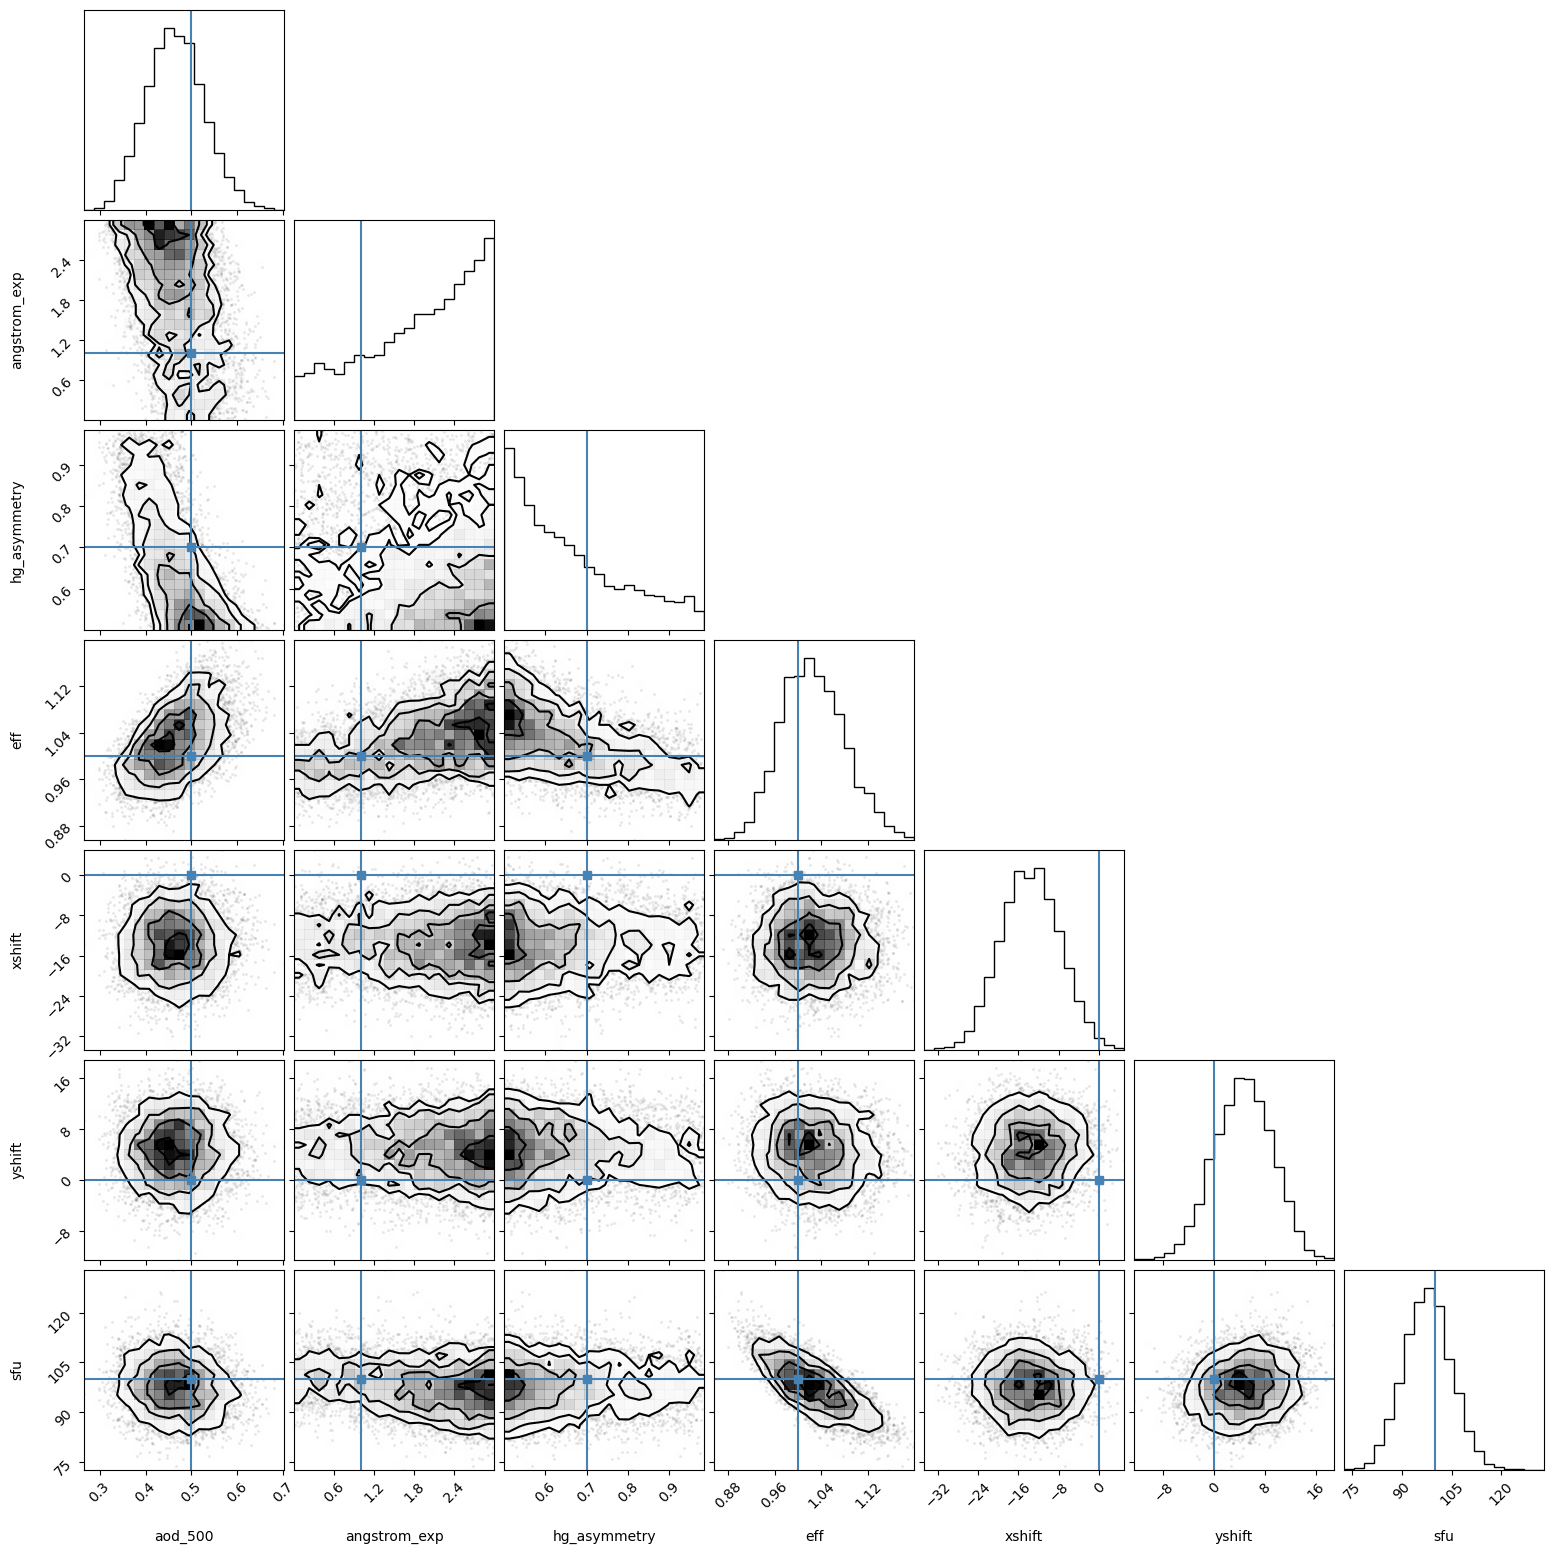

In [20]:
import corner
fig = corner.corner(flat_samples, labels=labels, truths=np.array(initial_params))

In [21]:
for i, name in enumerate(labels):
    p = flat_samples[:, i]
    median = np.median(p)
    lower = np.percentile(p, 16)
    upper = np.percentile(p, 84)
    print(f"{name} = {median:.3f} (+{upper-median:.3f}, -{median-lower:.3f})")

aod_500 = 0.464 (+0.063, -0.061)
angstrom_exp = 2.026 (+0.718, -1.151)
hg_asymmetry = 0.627 (+0.187, -0.097)
eff = 1.024 (+0.057, -0.051)
xshift = -13.601 (+5.829, -5.849)
yshift = 4.638 (+4.533, -4.683)
sfu = 97.655 (+7.167, -7.003)
